In [ ]:
!pip install ray torchinfo
!pip install -U tensorboardx

In [ ]:
import ray
from ray import tune
from ray.air import session
from ray.air.checkpoint import Checkpoint
from ray.tune.schedulers import ASHAScheduler

In [ ]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from torch.optim import lr_scheduler
from torchvision.transforms import ToTensor
from torchinfo import summary
import matplotlib.pyplot as plt

### Dataset

In [ ]:
# Download training data
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

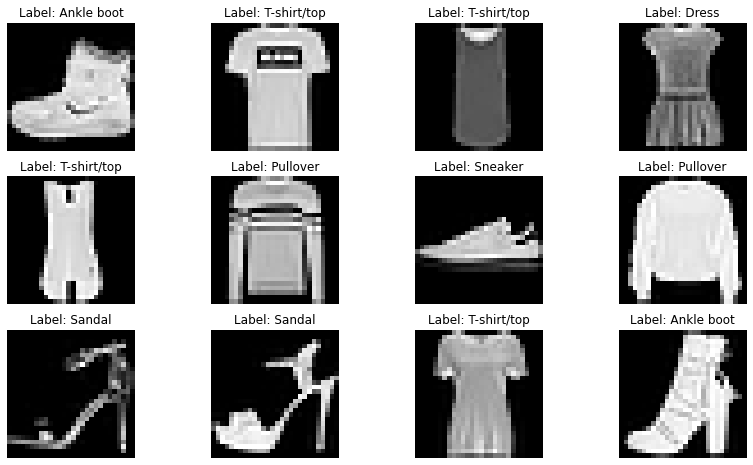

In [ ]:
# Samples of dataset
fig = plt.figure(figsize=(14,8))

for i in range(12):
    plt.subplot(3, 4, i+1)  
    plt.axis('off')
    title = f"Label: {train_data.classes[train_data[i][1]]}"
    plt.imshow(train_data[i][0].squeeze(), cmap="gray")
    plt.title(title)

In [ ]:
# Prepare train, val, and test set
np.random.seed(42)
indices = list(range(len(train_data)))
np.random.shuffle(indices)
val_num = int(np.floor(0.2 * len(train_data))) # 20% of trainset
train_set = SubsetRandomSampler(indices[:val_num])
val_set = SubsetRandomSampler(indices[val_num:])

In [ ]:
print(f"Size of subset, trainset: {len(train_set)}, valset: {len(val_set)}, testset: {len(test_data)}")

Size of subset, trainset: 12000, valset: 48000, testset: 10000


In [ ]:
batch_size = 128

train_dataloader = DataLoader(train_data, sampler=train_set, batch_size=batch_size)
val_dataloader = DataLoader(train_data, sampler=val_set, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([128, 1, 28, 28])
Shape of y:  torch.Size([128]) torch.int64


### Build CNN and MLP architecture

In [ ]:
class MLPNetwork(nn.Module):
  def __init__(self):
      super(MLPNetwork, self).__init__()
      self.fc1 = nn.Linear(28*28, 256)
      self.fc2 = nn.Linear(256, 128)
      self.fc3 = nn.Linear(128, 10)
      self.dropout = nn.Dropout(0.2) # Dropout to prevent overfitting

  def forward(self, x):
      x = x.view(x.size()[0], -1)
      x = self.dropout(nn.functional.relu(self.fc1(x)))
      x = self.dropout(nn.functional.relu(self.fc2(x)))
      x = nn.functional.log_softmax(self.fc3(x), dim=1)
      return x

In [ ]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(x.size()[0], -1)
        x = nn.functional.log_softmax(self.fc(x), dim=1)
        return x


In [ ]:
# CNN with Batch Normalization
class CNN_BN(nn.Module):
    def __init__(self):
        super(CNN_BN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.bn1 = nn.BatchNorm2d(10)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.bn2 = nn.BatchNorm2d(20)
        self.fc = nn.Linear(320, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(nn.functional.relu(self.bn1(x)))
        x = self.conv2(x)
        x = self.pool(nn.functional.relu(self.bn2(x)))
        x = x.view(x.size()[0], -1)
        x = nn.functional.log_softmax(self.fc(x), dim=1)
        return x

In [ ]:
def train_epoch(net, dataloader, lr=0.01, optimizer=None, loss_fn=nn.NLLLoss()):
    optimizer=optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    total_loss, acc, count = 0, 0, 0
    for features, labels in dataloader:
        features, labels = features.cuda(), labels.cuda()
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        pred = torch.max(out, 1)[1]
        acc += (pred==labels).sum()
        count += len(labels)
    return total_loss.item()/count, acc.item()/count


def validate(net, dataloader, loss_fn=nn.NLLLoss()):
    net.eval()
    count, acc, loss = 0, 0, 0
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.cuda(), labels.cuda()
            out = net(features)
            loss += loss_fn(out, labels)
            pred = torch.max(out, 1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

In [ ]:
def train(net, train_loader, val_loader,  optimizer=None, lr=0.01, epochs=10, loss_fn=nn.NLLLoss(), process=True):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl, ta = train_epoch(net, train_loader, optimizer=optimizer, lr=lr, loss_fn=loss_fn)
        vl, va = validate(net, val_loader, loss_fn=loss_fn)
        if process:
          print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

In [ ]:
def plot_performance(history):
  fig = plt.figure(figsize=(12, 5))
  epochs = len(history['train_loss']) 
  plt.subplot(1, 2, 1)
  plt.plot(np.arange(0, epochs), history['train_loss'], label='train loss')
  plt.plot(np.arange(0, epochs), history['val_loss'], label='val loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Loss vs. No. of epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(np.arange(0, epochs), history['train_acc'], label='train accuracy')
  plt.plot(np.arange(0, epochs), history['val_acc'], label='val accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')
  plt.legend()
  plt.show()

### Compare CNN, MLP and CNN with batch normalization

#### CNN

In [ ]:
cnn = MultiLayerCNN()
summary(cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

In [ ]:
cnn_hist = train(cnn, train_dataloader, val_dataloader, epochs=10)

Epoch  0, Train acc=0.709, Val acc=0.809, Train loss=0.006, Val loss=0.004
Epoch  1, Train acc=0.824, Val acc=0.836, Train loss=0.004, Val loss=0.004
Epoch  2, Train acc=0.847, Val acc=0.851, Train loss=0.003, Val loss=0.003
Epoch  3, Train acc=0.863, Val acc=0.860, Train loss=0.003, Val loss=0.003
Epoch  4, Train acc=0.870, Val acc=0.863, Train loss=0.003, Val loss=0.003
Epoch  5, Train acc=0.876, Val acc=0.858, Train loss=0.003, Val loss=0.003
Epoch  6, Train acc=0.881, Val acc=0.865, Train loss=0.003, Val loss=0.003
Epoch  7, Train acc=0.885, Val acc=0.860, Train loss=0.002, Val loss=0.003
Epoch  8, Train acc=0.890, Val acc=0.873, Train loss=0.002, Val loss=0.003
Epoch  9, Train acc=0.895, Val acc=0.866, Train loss=0.002, Val loss=0.003


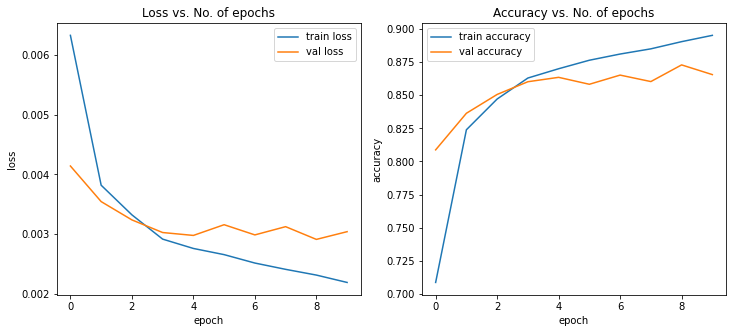

In [ ]:
plot_performance(cnn_hist)

In [ ]:
tl, ta = validate(cnn, test_dataloader, loss_fn=nn.NLLLoss())
print(f"Test accuracy = {ta:.3f}, Test loss={tl:.3f}")

Test accuracy = 0.857, Test loss=0.003


Predicted: "Ankle boot", Actual: "Ankle boot"


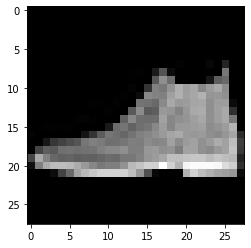

In [ ]:
cnn.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    img = x.cuda()
    out = cnn.forward(img.reshape(1, 1, 28, 28))
    pred = torch.max(out, 1)[1].item()
    print(f'Predicted: "{test_data.classes[pred]}", Actual: "{test_data.classes[y]}"')

plt.imshow(x.squeeze(), cmap="gray")

#### MLP

In [ ]:
mlp = MLPNetwork()
summary(mlp, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MLPNetwork                               [1, 10]                   --
├─Linear: 1-1                            [1, 256]                  200,960
├─Dropout: 1-2                           [1, 256]                  --
├─Linear: 1-3                            [1, 128]                  32,896
├─Dropout: 1-4                           [1, 128]                  --
├─Linear: 1-5                            [1, 10]                   1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
Total mult-adds (M): 0.24
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.94
Estimated Total Size (MB): 0.95

In [ ]:
mlp_hist = train(mlp, train_dataloader, val_dataloader, epochs=10)

Epoch  0, Train acc=0.657, Val acc=0.803, Train loss=0.007, Val loss=0.004
Epoch  1, Train acc=0.787, Val acc=0.825, Train loss=0.005, Val loss=0.004
Epoch  2, Train acc=0.807, Val acc=0.798, Train loss=0.004, Val loss=0.004
Epoch  3, Train acc=0.805, Val acc=0.817, Train loss=0.004, Val loss=0.004
Epoch  4, Train acc=0.815, Val acc=0.839, Train loss=0.004, Val loss=0.003
Epoch  5, Train acc=0.828, Val acc=0.847, Train loss=0.004, Val loss=0.003
Epoch  6, Train acc=0.822, Val acc=0.808, Train loss=0.004, Val loss=0.004
Epoch  7, Train acc=0.828, Val acc=0.844, Train loss=0.004, Val loss=0.003
Epoch  8, Train acc=0.834, Val acc=0.848, Train loss=0.004, Val loss=0.004
Epoch  9, Train acc=0.834, Val acc=0.832, Train loss=0.004, Val loss=0.004


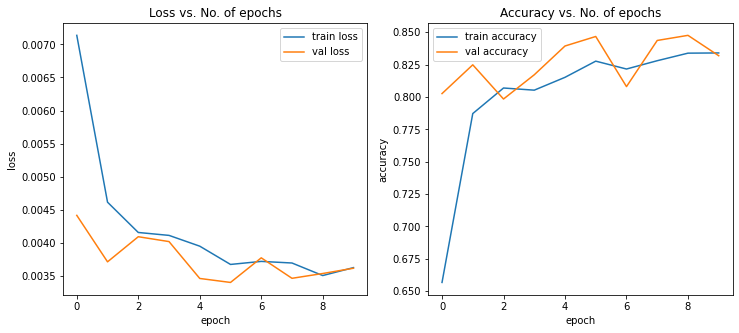

In [ ]:
plot_performance(mlp_hist)

In [ ]:
tl, ta = validate(mlp, test_dataloader, loss_fn=nn.NLLLoss())
print(f"Test accuracy = {ta:.3f}, Test loss={tl:.3f}")

Test accuracy = 0.820, Test loss=0.004


#### Batch Normalization

In [ ]:
cnn_bn = CNN_BN()
summary(cnn_bn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_BN                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─BatchNorm2d: 1-2                       [1, 10, 24, 24]           20
├─MaxPool2d: 1-3                         [1, 10, 12, 12]           --
├─Conv2d: 1-4                            [1, 20, 8, 8]             5,020
├─BatchNorm2d: 1-5                       [1, 20, 8, 8]             40
├─MaxPool2d: 1-6                         [1, 20, 4, 4]             --
├─Linear: 1-7                            [1, 10]                   3,210
Total params: 8,550
Trainable params: 8,550
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.03
Estimated Total Size (MB): 0.15

In [ ]:
cnn_bn_hist = train(cnn_bn, train_dataloader, val_dataloader, epochs=10)

Epoch  0, Train acc=0.761, Val acc=0.811, Train loss=0.005, Val loss=0.004
Epoch  1, Train acc=0.845, Val acc=0.845, Train loss=0.003, Val loss=0.004
Epoch  2, Train acc=0.862, Val acc=0.853, Train loss=0.003, Val loss=0.003
Epoch  3, Train acc=0.881, Val acc=0.863, Train loss=0.003, Val loss=0.003
Epoch  4, Train acc=0.889, Val acc=0.850, Train loss=0.002, Val loss=0.003
Epoch  5, Train acc=0.894, Val acc=0.864, Train loss=0.002, Val loss=0.003
Epoch  6, Train acc=0.904, Val acc=0.880, Train loss=0.002, Val loss=0.003
Epoch  7, Train acc=0.906, Val acc=0.869, Train loss=0.002, Val loss=0.003
Epoch  8, Train acc=0.916, Val acc=0.861, Train loss=0.002, Val loss=0.003
Epoch  9, Train acc=0.921, Val acc=0.880, Train loss=0.002, Val loss=0.003


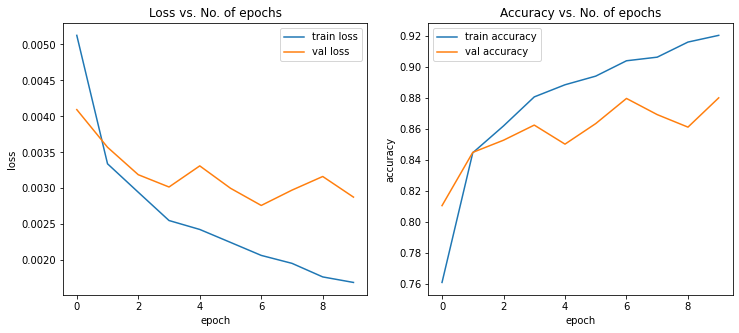

In [ ]:
plot_performance(cnn_bn_hist)

In [ ]:
tl, ta = validate(cnn_bn, test_dataloader, loss_fn=nn.NLLLoss())
print(f"Test accuracy = {ta:.3f}, Test loss={tl:.3f}")

Test accuracy = 0.875, Test loss=0.003


### Hyperparameters tuning



#### Different optimizer (SGD over Adam)

In [ ]:
cnn_bn = CNN_BN()
cnn_bn.cuda()

CNN_BN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=320, out_features=10, bias=True)
)

In [ ]:
cnn_hist_sgd = train(cnn_bn, train_dataloader, val_dataloader, optimizer=torch.optim.SGD(cnn_bn.parameters(), lr=0.01), epochs=10)

Epoch  0, Train acc=0.664, Val acc=0.745, Train loss=0.009, Val loss=0.006
Epoch  1, Train acc=0.768, Val acc=0.781, Train loss=0.006, Val loss=0.005
Epoch  2, Train acc=0.793, Val acc=0.801, Train loss=0.005, Val loss=0.005
Epoch  3, Train acc=0.811, Val acc=0.814, Train loss=0.004, Val loss=0.004
Epoch  4, Train acc=0.823, Val acc=0.822, Train loss=0.004, Val loss=0.004
Epoch  5, Train acc=0.832, Val acc=0.833, Train loss=0.004, Val loss=0.004
Epoch  6, Train acc=0.842, Val acc=0.838, Train loss=0.004, Val loss=0.004
Epoch  7, Train acc=0.847, Val acc=0.843, Train loss=0.003, Val loss=0.004
Epoch  8, Train acc=0.851, Val acc=0.845, Train loss=0.003, Val loss=0.003
Epoch  9, Train acc=0.856, Val acc=0.848, Train loss=0.003, Val loss=0.003


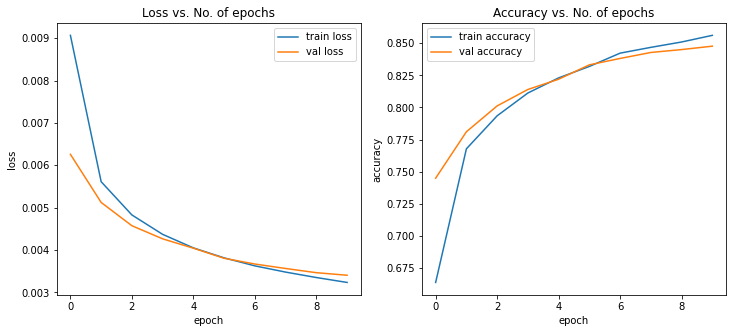

In [ ]:
plot_performance(cnn_hist_sgd)

In [ ]:
tl, ta = validate(cnn, test_dataloader, loss_fn=nn.NLLLoss())
print(f"Test accuracy = {ta:.3f}, Test loss={tl:.3f}")

Test accuracy = 0.857, Test loss=0.003


#### Tuning learning rate, batch size, number of nodes in linear layer

In [ ]:
class TuningCNN(nn.Module):
    def __init__(self, l1=128):
        super(TuningCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.bn1 = nn.BatchNorm2d(10)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.bn2 = nn.BatchNorm2d(20)
        self.fc1 = nn.Linear(320, l1)
        self.fc2 = nn.Linear(l1, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(nn.functional.relu(self.bn1(x)))
        x = self.conv2(x)
        x = self.pool(nn.functional.relu(self.bn2(x)))
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = nn.functional.log_softmax(self.fc2(x), dim=1)
        return x

##### Adam Optimizer

In [ ]:
def tune_train(config):
    # Tuning number of units in Linear layer
    net = TuningCNN(config["l1"])
    
    net.cuda()

    # Loss function and tuning learning rate of optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
    loss_fn=nn.NLLLoss()

    # To restore a checkpoint, use `session.get_checkpoint()`.
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           model_state, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    
    # Tuning batch size
    train_loader = DataLoader(train_data,
                              sampler=train_set, 
                              batch_size=int(config["batch_size"]), 
                              num_workers=1, 
                              pin_memory=True)
    val_loader = DataLoader(train_data, 
                            sampler=val_set,
                            batch_size=int(config["batch_size"]), 
                            num_workers=1, 
                            pin_memory=True)

    # Training with tuning parameters
    for epoch in range(10):
        # Training Phase 
        tl, ta = train_epoch(net, train_loader, optimizer=optimizer, lr=config["lr"], loss_fn=loss_fn)

        # Validation phase
        vl, va = validate(net, val_loader, loss_fn=loss_fn)
        
        # Here we save a checkpoint. It is automatically registered with
        # Ray Tune and can be accessed through `session.get_checkpoint()`
        # API in future iterations.
        os.makedirs("my_model", exist_ok=True)
        torch.save(
            (net.state_dict(), optimizer.state_dict()), "my_model/checkpoint.pt")
        checkpoint = Checkpoint.from_directory("my_model")
        session.report({"loss": vl, "accuracy": va}, checkpoint=checkpoint)
    
    print("Finished Training")

In [ ]:
num_samples = 27
max_num_epochs = 10
gpus_per_trial = 1

In [ ]:
config = {
    "l1": tune.choice([64, 128, 256]),
    "lr": tune.choice([1e-4, 1e-3, 1e-2]),
    "batch_size": tune.choice([32, 64, 128])
}

scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    
tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(tune_train),
        resources={"cpu": 2, "gpu": gpus_per_trial}
    ),
    tune_config=tune.TuneConfig(
        metric="loss",
        mode="min",
        scheduler=scheduler,
        num_samples=num_samples,
    ),
    param_space=config,
)

In [ ]:
results = tuner.fit()

Trial name,status,loc,batch_size,l1,lr,iter,total time (s),loss,accuracy
tune_train_acf1d_00000,TERMINATED,172.28.0.2:6700,64,64,0.01,10,96.972,0.0063063,0.866187
tune_train_acf1d_00001,TERMINATED,172.28.0.2:6700,128,128,0.0001,1,7.4071,0.00886682,0.691167
tune_train_acf1d_00002,TERMINATED,172.28.0.2:6700,128,64,0.001,10,72.8232,0.00290222,0.8735
tune_train_acf1d_00003,TERMINATED,172.28.0.2:6700,128,256,0.01,10,71.0484,0.00310922,0.86925
tune_train_acf1d_00004,TERMINATED,172.28.0.2:6700,32,128,0.0001,1,12.2575,0.0215495,0.759125
tune_train_acf1d_00005,TERMINATED,172.28.0.2:6700,64,64,0.01,1,9.15217,0.0091449,0.792646
tune_train_acf1d_00006,TERMINATED,172.28.0.2:6700,64,256,0.0001,1,9.18021,0.0118035,0.747375
tune_train_acf1d_00007,TERMINATED,172.28.0.2:6700,32,128,0.0001,1,12.3034,0.022036,0.763437
tune_train_acf1d_00008,TERMINATED,172.28.0.2:6700,128,128,0.01,8,58.393,0.00309437,0.863417
tune_train_acf1d_00009,TERMINATED,172.28.0.2:6700,64,64,0.01,2,18.1313,0.00636558,0.854521


2022-10-12 04:24:04,799	WARNING worker.py:1829 -- Warning: The actor ImplicitFunc is very large (45 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-10-12 04:24:05,710	WARNING util.py:220 -- The `start_trial` operation took 1.558 s, which may be a performance bottleneck.


Result for tune_train_acf1d_00000:
  accuracy: 0.8054791666666666
  date: 2022-10-12_04-24-25
  done: false
  experiment_id: 2f91ab833f9446638954294d0ed5aee2
  hostname: 658f6e669cd1
  iterations_since_restore: 1
  loss: 0.008147857666015624
  node_ip: 172.28.0.2
  pid: 6700
  should_checkpoint: true
  time_since_restore: 14.559859275817871
  time_this_iter_s: 14.559859275817871
  time_total_s: 14.559859275817871
  timestamp: 1665548665
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: acf1d_00000
  warmup_time: 0.0077610015869140625
  
Result for tune_train_acf1d_00000:
  accuracy: 0.8410625
  date: 2022-10-12_04-24-34
  done: false
  experiment_id: 2f91ab833f9446638954294d0ed5aee2
  hostname: 658f6e669cd1
  iterations_since_restore: 2
  loss: 0.007124048233032226
  node_ip: 172.28.0.2
  pid: 6700
  should_checkpoint: true
  time_since_restore: 23.41377329826355
  time_this_iter_s: 8.853914022445679
  time_total_s: 23.41377329826355
  timestamp: 1665548674
  timesteps_s

2022-10-12 04:34:02,969	INFO tune.py:759 -- Total run time: 611.95 seconds (610.85 seconds for the tuning loop).


In [ ]:
best_result = results.get_best_result("loss", "min")

print("Best trial config: {}".format(best_result.config))
print("Best trial final validation loss: {}".format(
    best_result.metrics["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_result.metrics["accuracy"]))

Best trial config: {'l1': 64, 'lr': 0.001, 'batch_size': 128}
Best trial final validation loss: 0.002902223269144694
Best trial final validation accuracy: 0.8735


##### SGD Optimizer

In [ ]:
def tune_train_sgd(config):
    # Tuning number of units in Linear layer
    net = TuningCNN(config["l1"])
    
    net.cuda()

    # Loss function and tuning learning rate of optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=config["lr"])
    loss_fn=nn.NLLLoss()

    # To restore a checkpoint, use `session.get_checkpoint()`.
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           model_state, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    
    # Tuning batch size
    train_loader = DataLoader(train_data,
                              sampler=train_set, 
                              batch_size=int(config["batch_size"]), 
                              num_workers=1, 
                              pin_memory=True)
    val_loader = DataLoader(train_data, 
                            sampler=val_set,
                            batch_size=int(config["batch_size"]), 
                            num_workers=1, 
                            pin_memory=True)

    # Training with tuning parameters
    for epoch in range(10):
        # Training Phase 
        tl, ta = train_epoch(net, train_loader, optimizer=optimizer, lr=config["lr"], loss_fn=loss_fn)

        # Validation phase
        vl, va = validate(net, val_loader, loss_fn=loss_fn)
        
        # Here we save a checkpoint. It is automatically registered with
        # Ray Tune and can be accessed through `session.get_checkpoint()`
        # API in future iterations.
        os.makedirs("my_model_sgd", exist_ok=True)
        torch.save(
            (net.state_dict(), optimizer.state_dict()), "my_model_sgd/checkpoint.pt")
        checkpoint = Checkpoint.from_directory("my_model_sgd")
        session.report({"loss": vl, "accuracy": va}, checkpoint=checkpoint)
    
    print("Finished Training")

In [ ]:
num_samples = 27
max_num_epochs = 10
gpus_per_trial = 1

In [ ]:
config = {
    "l1": tune.choice([64, 128, 256]),
    "lr": tune.choice([1e-4, 1e-3, 1e-2]),
    "batch_size": tune.choice([32, 64, 128])
}

scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    
tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(tune_train_sgd),
        resources={"cpu": 2, "gpu": gpus_per_trial}
    ),
    tune_config=tune.TuneConfig(
        metric="loss",
        mode="min",
        scheduler=scheduler,
        num_samples=num_samples,
    ),
    param_space=config,
)

In [ ]:
results_sgd = tuner.fit()

2022-10-14 01:25:37,279	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-14 01:25:39,609	WARNING function_trainable.py:620 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,batch_size,l1,lr,iter,total time (s),loss,accuracy
tune_train_sgd_1df77_00000,TERMINATED,172.28.0.2:371,32,128,0.0001,10,129.275,0.0467116,0.643312
tune_train_sgd_1df77_00001,TERMINATED,172.28.0.2:371,32,128,0.01,10,115.809,0.011214,0.873021
tune_train_sgd_1df77_00002,TERMINATED,172.28.0.2:371,64,128,0.0001,10,84.5936,0.0292318,0.492229
tune_train_sgd_1df77_00003,TERMINATED,172.28.0.2:371,64,64,0.0001,4,33.5422,0.0334248,0.222208
tune_train_sgd_1df77_00004,TERMINATED,172.28.0.2:371,128,256,0.001,10,69.604,0.00717465,0.727292
tune_train_sgd_1df77_00005,TERMINATED,172.28.0.2:371,32,128,0.0001,1,11.6956,0.0671593,0.23625
tune_train_sgd_1df77_00006,TERMINATED,172.28.0.2:371,32,256,0.001,1,11.9584,0.0423066,0.678625
tune_train_sgd_1df77_00007,TERMINATED,172.28.0.2:371,32,64,0.001,1,11.8449,0.0486677,0.630854
tune_train_sgd_1df77_00008,TERMINATED,172.28.0.2:371,64,64,0.0001,2,17.0592,0.0350728,0.139437
tune_train_sgd_1df77_00009,TERMINATED,172.28.0.2:371,32,64,0.001,1,11.7825,0.0476746,0.644208


2022-10-14 01:25:51,464	WARNING worker.py:1829 -- Warning: The actor ImplicitFunc is very large (45 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Result for tune_train_sgd_1df77_00000:
  accuracy: 0.172625
  date: 2022-10-14_01-26-17
  done: false
  experiment_id: fc3ea0f354e24bcb997d1eb518d96c9d
  hostname: 83f84b03f699
  iterations_since_restore: 1
  loss: 0.06987553405761719
  node_ip: 172.28.0.2
  pid: 371
  should_checkpoint: true
  time_since_restore: 22.87206721305847
  time_this_iter_s: 22.87206721305847
  time_total_s: 22.87206721305847
  timestamp: 1665710777
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1df77_00000
  warmup_time: 0.0030803680419921875
  
Result for tune_train_sgd_1df77_00000:
  accuracy: 0.30702083333333335
  date: 2022-10-14_01-26-28
  done: false
  experiment_id: fc3ea0f354e24bcb997d1eb518d96c9d
  hostname: 83f84b03f699
  iterations_since_restore: 2
  loss: 0.06618158976236979
  node_ip: 172.28.0.2
  pid: 371
  should_checkpoint: true
  time_since_restore: 34.31216859817505
  time_this_iter_s: 11.440101385116577
  time_total_s: 34.31216859817505
  timestamp: 1665710788
  timesteps

2022-10-14 01:45:02,825	INFO tune.py:759 -- Total run time: 1163.22 seconds (1160.43 seconds for the tuning loop).


In [ ]:
best_result_sgd = results_sgd.get_best_result("loss", "min")

print("Best trial config: {}".format(best_result_sgd.config))
print("Best trial final validation loss: {}".format(
    best_result_sgd.metrics["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_result_sgd.metrics["accuracy"]))

Best trial config: {'l1': 64, 'lr': 0.01, 'batch_size': 64}
Best trial final validation loss: 0.0066129894256591795
Best trial final validation accuracy: 0.8484166666666667


### Final train

In [ ]:
# Train with learning rate scheduler
def train_lr_step(net, train_loader, val_loader, optim=None, lr=0.01, epochs=10, step=10, process=True):
    optimizer = optim or torch.optim.Adam(net.parameters(), lr=lr)
    # lr scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step, gamma=0.1)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl, ta = train_epoch(net, train_loader, optimizer=optimizer, lr=lr)
        vl, va = validate(net, val_loader)
        scheduler.step()
        if process:
          print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

#### Adam best config

In [ ]:
best_config = best_result.config
# best_config = {'l1': 64, 'lr': 0.01, 'batch_size': 64}

In [ ]:
train_dataloader = DataLoader(train_data, sampler=train_set, batch_size=best_config['batch_size'])
val_dataloader = DataLoader(train_data, sampler=val_set, batch_size=best_config['batch_size'])
test_dataloader = DataLoader(test_data, batch_size=best_config['batch_size'])

In [ ]:
net = TuningCNN(best_config["l1"])
net.cuda()

TuningCNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=320, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
final_hist = train_lr_step(net, train_dataloader, val_dataloader, lr=0.01, epochs=30)

Epoch  0, Train acc=0.760, Val acc=0.816, Train loss=0.005, Val loss=0.004
Epoch  1, Train acc=0.833, Val acc=0.814, Train loss=0.004, Val loss=0.004
Epoch  2, Train acc=0.856, Val acc=0.855, Train loss=0.003, Val loss=0.003
Epoch  3, Train acc=0.870, Val acc=0.862, Train loss=0.003, Val loss=0.003
Epoch  4, Train acc=0.881, Val acc=0.859, Train loss=0.003, Val loss=0.003
Epoch  5, Train acc=0.884, Val acc=0.861, Train loss=0.002, Val loss=0.003
Epoch  6, Train acc=0.896, Val acc=0.871, Train loss=0.002, Val loss=0.003
Epoch  7, Train acc=0.902, Val acc=0.857, Train loss=0.002, Val loss=0.004
Epoch  8, Train acc=0.906, Val acc=0.862, Train loss=0.002, Val loss=0.003
Epoch  9, Train acc=0.911, Val acc=0.858, Train loss=0.002, Val loss=0.003
Epoch 10, Train acc=0.938, Val acc=0.884, Train loss=0.001, Val loss=0.003
Epoch 11, Train acc=0.945, Val acc=0.885, Train loss=0.001, Val loss=0.003
Epoch 12, Train acc=0.948, Val acc=0.885, Train loss=0.001, Val loss=0.003
Epoch 13, Train acc=0.952

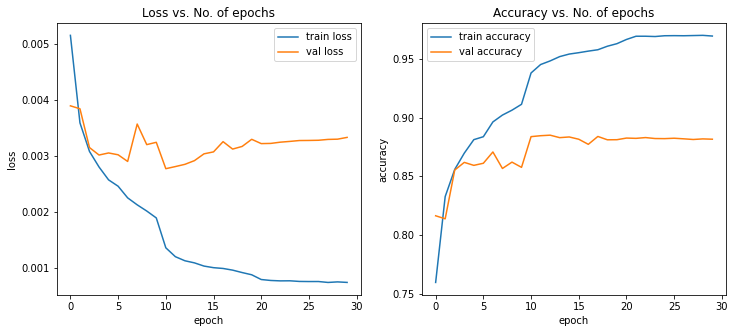

In [ ]:
plot_performance(final_hist)

In [ ]:
tl, ta = validate(net, test_dataloader, loss_fn=nn.NLLLoss())
print(f"Test accuracy = {ta:.3f}, Test loss={tl:.3f}")

Test accuracy = 0.880, Test loss=0.003


#### SGD best config

In [ ]:
best_config = best_result_sgd.config
# best_config = {'l1': 64, 'lr': 0.001, 'batch_size': 128}

In [ ]:
train_dataloader = DataLoader(train_data, sampler=train_set, batch_size=best_config['batch_size'])
val_dataloader = DataLoader(train_data, sampler=val_set, batch_size=best_config['batch_size'])
test_dataloader = DataLoader(test_data, batch_size=best_config['batch_size'])

In [ ]:
net = TuningCNN(best_config["l1"])
net.cuda()

TuningCNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=320, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
final_hist = train_lr_step(net, train_dataloader, val_dataloader, 
                           optim=torch.optim.SGD(net.parameters(), lr=best_config['lr']), lr=best_config['lr'], epochs=60, step=35)

Epoch  0, Train acc=0.651, Val acc=0.743, Train loss=0.019, Val loss=0.012
Epoch  1, Train acc=0.771, Val acc=0.783, Train loss=0.011, Val loss=0.010
Epoch  2, Train acc=0.802, Val acc=0.793, Train loss=0.009, Val loss=0.009
Epoch  3, Train acc=0.822, Val acc=0.826, Train loss=0.008, Val loss=0.008
Epoch  4, Train acc=0.840, Val acc=0.820, Train loss=0.007, Val loss=0.008
Epoch  5, Train acc=0.845, Val acc=0.835, Train loss=0.007, Val loss=0.007
Epoch  6, Train acc=0.857, Val acc=0.821, Train loss=0.006, Val loss=0.007
Epoch  7, Train acc=0.863, Val acc=0.852, Train loss=0.006, Val loss=0.007
Epoch  8, Train acc=0.865, Val acc=0.855, Train loss=0.006, Val loss=0.006
Epoch  9, Train acc=0.869, Val acc=0.858, Train loss=0.006, Val loss=0.006
Epoch 10, Train acc=0.875, Val acc=0.851, Train loss=0.005, Val loss=0.006
Epoch 11, Train acc=0.877, Val acc=0.856, Train loss=0.005, Val loss=0.006
Epoch 12, Train acc=0.882, Val acc=0.848, Train loss=0.005, Val loss=0.007
Epoch 13, Train acc=0.888

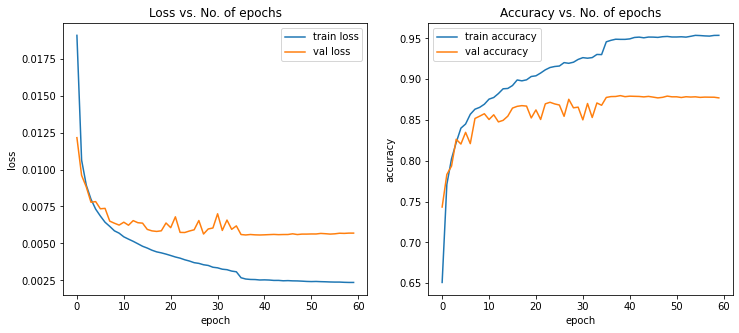

In [ ]:
plot_performance(final_hist)

In [ ]:
tl, ta = validate(net, test_dataloader, loss_fn=nn.NLLLoss())
print(f"Test accuracy = {ta:.3f}, Test loss={tl:.3f}")

Test accuracy = 0.872, Test loss=0.006
